In [1]:
%cd ..
from motion_planner import MotionPlanner, Trajectory, RobotModel
import numpy as np, matplotlib.pyplot as plt

/home/stephen/Desktop/LASA/epfl-lasa/mpc_motion_planner


### Create your motion planner

In [2]:
planner = MotionPlanner(RobotModel.Panda)

### Set boundary conditions

In [3]:
# Initial state, for instance :
qlim =planner._robot_utils.X_limits
qdotlim = planner._robot_utils.V_limits
q0, dq0, ddq0 = planner.sample_state(set_qddot_to_zero=True)
qd, dqd, ddqd = planner.sample_state(set_qddot_to_zero=True)


planner.set_current_state((q0, dq0, ddq0))
planner.set_target_state((qd, dqd, ddqd))

### Solve and get trajectory

In [4]:
info = planner.solve()
print(info)

{'status': 1, 'iter': 3, 'time_to_solve': 0.06631088256835938}


In [5]:
traj = planner.get_trajectory()
traj_ruckig = planner.get_trajectory(ruckig=True)

If you have several trajectories to compute, you can concatenate these by using the "+" operator :

In [6]:
print("Shape of traj is initially : {} ({} trajectory of {} time-steps)".format(traj.shape, *traj.shape))
traj += traj_ruckig
print("After using the + operator traj has now shape : {} ({} trajectories of {} time-steps each)".format(traj.shape, *traj.shape))

Shape of traj is initially : (1, 101) (1 trajectory of 101 time-steps)
After using the + operator traj has now shape : (2, 101) (2 trajectories of 101 time-steps each)


### Accessing t, q, qdot, qddot and tau
To access the results, you can use one of these notations:

In [7]:
t = traj["t"]
q = traj.q
qdot = traj["qdot"][0] # If you want to access the first q trajectory
t, q, qdot, qddot, tau = traj[1] # If you want to get all the state from the second trajectory at once

# 
# etc ..
#

print(t.shape, q.shape, qdot.shape, qddot.shape, tau.shape)

(101,) (101, 7) (101, 7) (101, 7) (101, 7)


### Trajectory analysis
The .get_trajectory() method returns a Trajectory object that provides several useful analysis methods. To check if the trajectories satisfy all the constraints: 

In [8]:
print("Constraint satisfied : {}".format(traj.all_cons_satisfied))

Constraint satisfied : [False  True]


the .all_cons_satisfied attribute **returns one boolean per trajectory stored!** You can also assess each constraint separately by accessing the attributes :
- .q_cons_satisfied
- .qdot_cons_satisfied
- .qddot_cons_satisfied
- .tau_cons_satisfied

### Compute Power
You can access the total power of a trajectory by using the property .power.

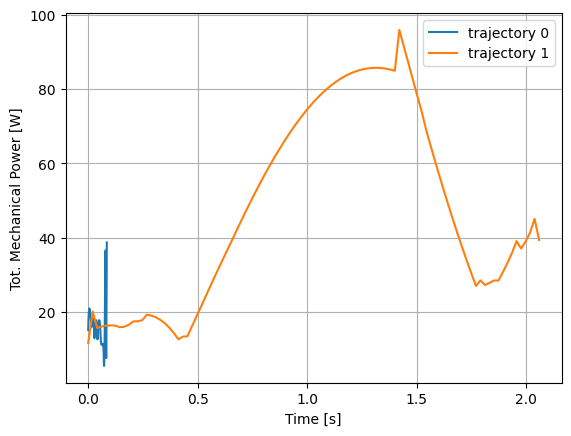

In [9]:
plt.figure()
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel("Tot. Mechanical Power [W]")
for i in range(len(traj)):
    plt.plot(traj.t[i], traj.power[i], label="trajectory {}".format(i))
plt.legend()